# week 2: simulation results & make your own algorithm simulation

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import pickle

import os
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib 
# import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.ticker import MultipleLocator

# -----
# part 1: load competition details & visualize

In [ ]:
df_comp_details = pd.read_csv('duopoly_competition_details_quentin.csv')
df_comp_details.fillna(0, inplace=True)
df_comp_details['competition_id'].nunique()

3

#### check how many competitions (one set it 100 selling seasons) we ran against each competitor
- when two opponents are selected for a 'battle' they perform 4 competitions
- during one night you can be drawn twice to compete against the same competitor

In [ ]:
df_comp_details.groupby('competitor_id').agg({
    'competition_id' : 'nunique',
    'selling_season' : ['max', 'count']
})

competition_id selling_season       
                         nunique            max  count
competitor_id                                         
IncredibleDogfish              1            100  10000
NoisyMammoth                   2            100  20000

In [ ]:
df_comp_details['unique_selling_season_key'] = df_comp_details.apply(lambda r:
                                "%s_%s" % (r.competition_id,r.selling_season), axis=1)

df_comp_details.head(3)

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,unique_selling_season_key
0,3JbhUV,1,1,NoisyMammoth,48.0,40.4,0,True,0.0,0.0,3JbhUV_1
1,3JbhUV,1,2,NoisyMammoth,40.0,60.6,0,True,0.0,0.0,3JbhUV_1
2,3JbhUV,1,3,NoisyMammoth,47.4,46.6,0,True,0.0,0.0,3JbhUV_1


# ----
# part 2: simulate a basic pricing algorithm with data from the competition details CSV

### When simulating the DPC demand algorithms based on the competition details CSV, consider the shifted time information structure
- when requested to return the price for selling period 1, we only have the information that the competitor has capacity to sell, but no demand and pricing information from the previous selling period (since there is no)
- when requesting the price for selling_period 2, the pricing function will receive the information on the prices (including the competitor's) from the last period (1) and the realized demand from the previous selling_period
- ...

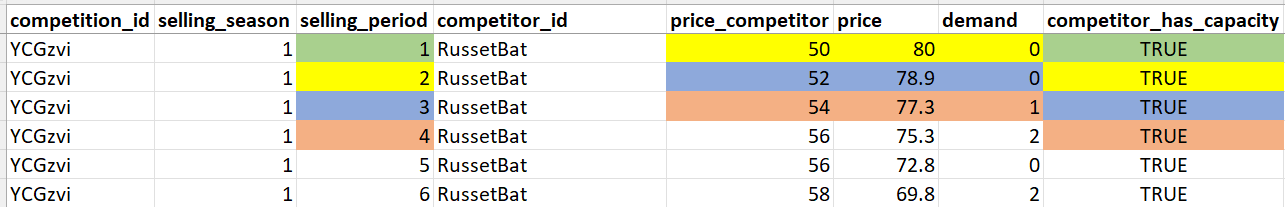

#### pre-step: delete potential exisiting 'duopoly_feedback.data'

In [ ]:
if os.path.isfile('duopoly_feedback.data'):
    os.remove('duopoly_feedback.data')
    print('duopoly_feedback.data deleted')
else:
    print('duopoly_feedback.data does not exists')

duopoly_feedback.data does not exists


#### reload the pricing algo, in case you made changes

In [ ]:
import duopoly_simple as duopoly
reload(duopoly)

<module 'duopoly_simple' from 'c:\\Users\\yannl\\Documents\\BHT\\LearningOptimization\\DynamicPricingCompet\\W2\\duopoly_simple.py'>

In [ ]:
df_comp_details.demand.describe()

count    30000.000000
mean         0.690767
std          1.080083
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: demand, dtype: float64

### loop over the selling_period (starting at 1 with the initialization) and call the price function from your algo

In [ ]:
s = 1 # first selling season
max_t = 20 # selling period until we want to run the simulation
information_dump = None
my_prices = []

# select form the competition details CSV which selling_season 
# you want to use for the simulation
id = df_comp_details['unique_selling_season_key'].unique()[0]
df_select = df_comp_details[df_comp_details.unique_selling_season_key==id]

# loop over the selling periods t
for t in np.arange(1,(max_t+1),1):
    
    print("we are in selling_period = %d" % t)

    if t <=1 :
        prices_historical = None
        demand_historical = None
    else:
        # get price info from details CSV
        prices_historical = [ my_prices, 
                              df_select[df_select.selling_period < t]['price_competitor'] ]
        prices_historical  = np.array(prices_historical)
        # get demand info from details CSV
        demand_historical  = np.array(df_select[df_select.selling_period < t]['demand'])

    # get current info if competitor can sell
    competitor_has_capacity = df_select[df_select.selling_period == t]['competitor_has_capacity'].values[0]
    
    # build input object for price algo
    request_input = {
        "current_selling_season" : s, 
        "selling_period_in_current_season" : t,
        "prices_historical_in_current_season" : prices_historical, 
        "demand_historical_in_current_season" : demand_historical, 
        "competitor_has_capacity_current_period_in_current_season" : competitor_has_capacity, 
        "information_dump": information_dump
    }
    # request price from you algo and receive (price, information_dump)
    price , information_dump = duopoly.p(**request_input)
    
    print("###")
    print("We received from the algo the following results:")
    print("price: %.2f" % price)
    print("information_dump: %s" % str(information_dump) )
    # add you price to the own prices arroy
    my_prices.append(price)

we are in selling_period = 1
 	 Algo: ---
 	 Algo: we are in selling_season 1 and selling_period 1
 	 Algo: setting random price at init: 53.761
 	 Algo: so far we have generated revenue: 0.00
 	 Algo: my next price is: 53.76
 	 Algo: ---
###
We received from the algo the following results:
price: 53.76
information_dump: {'revenue': 0}
we are in selling_period = 2
 	 Algo: ---
 	 Algo: we are in selling_season 1 and selling_period 2
 	 Algo: random_draw_4_price_change: 0.139  => setting new price: True
 	 Algo: new price is: 66.22
 	 Algo: so far we have generated revenue: 0.00
 	 Algo: my next price is: 66.22
 	 Algo: ---
###
We received from the algo the following results:
price: 66.22
information_dump: {'revenue': 0.0}
we are in selling_period = 3
 	 Algo: ---
 	 Algo: we are in selling_season 1 and selling_period 3
 	 Algo: random_draw_4_price_change: 0.490  => setting new price: False
 	 Algo: keeping old price
 	 Algo: so far we have generated revenue: 0.00
 	 Algo: my next price